In [23]:
import tensorflow as tf
import logging
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.ERROR)
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import sys
import pickle
from functools import partial
import scipy.stats as sts
 
plt.rcParams.update({'font.size': 16,                                                                                                                                                    
                     'axes.labelsize': 16, 'legend.fontsize': 12, 
                     'xtick.labelsize': 16, 'ytick.labelsize': 16, 'axes.titlesize': 16,
                     'axes.linewidth': 1.5}) 

In [65]:
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions


class MDN():
    def __init__(self, k, dim):
        self.k = k
        self.dim = dim
        
    def alpha_model(self, depth, activation='relu', max_units=256):
        units_pow = np.log2(max_units)
        def model(x, units_pow=units_pow, activation=activation, depth=depth):
            for ii in range(depth):
                units_cu = max(2**units_pow, self.k)
                net = tf.keras.layers.Dense(units_cu, activation=activation)(x)
                units_pow-=1
            net = tf.keras.layers.Dense(self.k, activation='softmax')(x)
            return net
        return model
                    
    def Ls_model(self,depth, activation='relu', max_units=256):
        output_dim = ((self.dim)**2+self.dim)/2
        b = tfb.FillScaleTriL(diag_bijector = tfb.Exp(),diag_shift=None)
        units_pow = np.log2(max_units)
        def model(x, units_pow=units_pow, activation=activation, depth=depth, output_dim=output_dim):
            for ii in range(depth):
                units_cu = max(2**units_pow, self.dim)
                net = tf.keras.layers.Dense(units_cu, activation=activation)(x)
                units_pow-=1
            net = tf.keras.layers.Dense(output_dim)(x)
            Ls  = b.forward(net)

            return Ls
        return model
            
    def mean_model(self, depth,activation, max_units=256):
        units_pow = np.log2(max_units)
        def model(x, units_pow=units_pow, activation=activation, depth=depth):
            for ii in range(depth):
                units_cu = max(2**units_pow, self.dim)
                net = tf.keras.layers.Dense(units_cu, activation=activation)(x)
                units_pow-=1
            net = tf.keras.layers.Dense(self.dim, activation)(x)
            return net
        return model
        
    def construct_model(self, depths, activation):
        
        self.alphas = []
        self.Ls     = []
        self.means  = []
        self.alphas=self.alpha_model(depths, activation)
        for ii in range(self.k):
            
            self.Ls.append(self.Ls_model(depths, activation))
            self.means.append(self.mean_model(depths,activation))
                               
     
    def GMM(self,x):
        alphas = self.alphas(x)
        comps  = [tfd.MultivariateNormalTriL(loc=mean(x), scale_tril=L(x)) for mean, L in zip(self.means,self.Ls)]
        GMM    = tfd.Mixture(cat=tfd.Categorical(probs=alphas),components=comps)
                               
        return GMM
                               
    def logp(self, x_in, x_eval):
        GMM = self.GMM(x_in)
        return GMM.log_prob(x_eval)
                               
    def sample(self,x_in, size):
        GMM = self.GMM(x_in)
        return GMM.sample(size)
                               

In [66]:
myMDN = MDN(3,2)
myMDN.construct_model(2,'relu')

<tf.Tensor: shape=(1, 10000, 2), dtype=float32, numpy=
array([[[-0.34093693, -0.94487476],
        [-0.18821527, -0.53364336],
        [ 0.28107294, -0.7996807 ],
        ...,
        [-0.40378478,  2.4958935 ],
        [ 1.2945344 ,  2.9106352 ],
        [ 0.13496521,  4.3595486 ]]], dtype=float32)>

In [67]:
dim = 2
k   = 3
means = np.asarray([[1,1],[2,2],[5,5]])
covs  = [[[0.8,0.5],[0.5,0.8]],[[2,-1.5],[-1.5,2]], [[1,0.5],[0.5,1]]]
weights = [0.4, 0.4, 0.2]
  

In [68]:
batch_size = 128
lr         = 1e-3

In [69]:
gaussians =[]
for ii in range(k):
    gaussians+=[sts.multivariate_normal(mean=means[ii], cov=covs[ii])]
    
cat = sts.multinomial(1,weights, seed=None)

In [70]:
import matplotlib.cm as cm

In [71]:
def sample(num):
    samples =[]
    inds = np.where(cat.rvs(num)==1)[1]
    for ind in inds:
        samples.append(gaussians[ind].rvs(1))
    return np.asarray(samples), inds

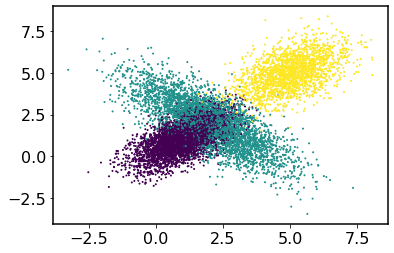

In [72]:
train_samples, inds = sample(100000)

plt.scatter(train_samples[:10000,0], train_samples[:10000,1], c=inds[:10000], s=1)
plt.show()

In [73]:
myMDN.logp(samples, samples)

<tf.Tensor: shape=(10000,), dtype=float32, numpy=
array([-3.5997272, -3.0185125, -4.8530602, ..., -3.322561 , -3.7024527,
       -7.1558747], dtype=float32)>

In [101]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
input1    = tf.keras.Input(shape=dim)
input2    = tf.keras.Input(shape=dim)
model     = tf.keras.Model(inputs=[input1, input2], outputs=myMDN.logp(input1, input2))


In [102]:
model([input1, input2])

<tf.Tensor 'model_8/Identity:0' shape=(None,) dtype=float32>

In [103]:
def loss(model, x):
    y = -tf.reduce_mean(model([x,x]))
    return y


In [104]:
loss(model, train_samples)

<tf.Tensor: shape=(), dtype=float32, numpy=7.5062075>

In [105]:
def grad(model, inputs):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)


In [106]:
## Note: Rerunning this cell uses the same model variables

# Keep results for plotting
train_loss_results     = []
train_accuracy_results = []

num_epochs = 15

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()

    # Training loop - using batches of 32
    for ii in range(len(train_samples)//batch_size):
    # Optimize the model
        x = train_samples[ii*batch_size:(ii+1)*batch_size]
        loss_value, grads = grad(model, x)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Track progress
        epoch_loss_avg.update_state(loss_value)  # Add current batch loss
        train_loss_results.append(epoch_loss_avg.result())
    np.random.shuffle(train_samples)
    if epoch % 1 == 0:
        print("Epoch {:03d}: Loss: {:.3f}".format(epoch,epoch_loss_avg.result()))


Epoch 000: Loss: 3.163
Epoch 001: Loss: 0.867
Epoch 002: Loss: 0.643
Epoch 003: Loss: 0.049
Epoch 004: Loss: -0.379
Epoch 005: Loss: -0.288
Epoch 006: Loss: -0.497
Epoch 007: Loss: -0.393


KeyboardInterrupt: 

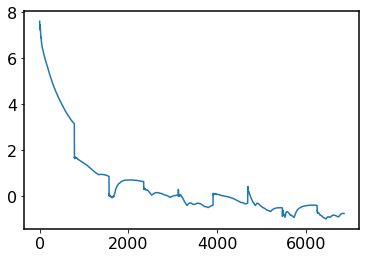

In [107]:
plt.plot(train_loss_results)

In [114]:
myMDN.sample(samples,1).shape

TensorShape([1, 10000, 2])

In [113]:
print(samples.shape, train_samples.shape)

(10000, 2) (100000, 2)
